<a href="https://colab.research.google.com/github/hamingsi/potential-journey/blob/main/feature_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 如果使用feature map 需要更换网络结构至LeNet-5

import time
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import sys
sys.path.append("..") 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3), # in_channels, out_channels, kernel_size
            nn.ReLU(),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(p=0.2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(p=0.2),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 128, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.Dropout(p=0.2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 84),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(84, 10)
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

In [ ]:
net = LeNet()
print(net)

LeNet(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.2, inplace=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Dropout(p=0.2, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_fea

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# 数据自动下载链接，并保存到本地
train_data = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=True,
                                          download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=False,
                                         download=True, transform=transform)

K = 5000

# train_data.data = train_data.data[:K]
# train_data.targets = train_data.targets[:K]
# test_data.data = test_data.data[:K]
# test_data.targets = test_data.targets[:K]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


In [ ]:
batch_size = 512
train_iter = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用。该函数将被逐步改进。
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train() # 改回训练模式
            else: # 自定义的模型, 3.13节之后不会用到, 不考虑GPU
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n

In [ ]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    loss = torch.nn.CrossEntropyLoss()
    loss_all, train_acc_all, test_acc_all = [], [], []
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        loss_all.append(train_l_sum / batch_count)
        train_acc_all.append(train_acc_sum / n)
        test_acc_all.append(test_acc)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
    return loss_all, train_acc_all, test_acc_all

In [ ]:
lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
epoch = [5, 10, 20, 50, 100]
# for i in range(5):
#   net = LeNet()
#   num_epochs = epoch[i]
num_epochs = 30
loss_all, train_acc_all, test_acc_all = train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)
#   loss_all.append(loss)
#   train_acc_all.append(train_acc)
#   test_acc_all.append(test_acc)

training on  cuda
epoch 1, loss 2.0377, train acc 0.218, test acc 0.336, time 22.9 sec
epoch 2, loss 1.7230, train acc 0.349, test acc 0.379, time 17.8 sec
epoch 3, loss 1.5890, train acc 0.401, test acc 0.432, time 15.9 sec
epoch 4, loss 1.4849, train acc 0.444, test acc 0.482, time 15.8 sec
epoch 5, loss 1.3916, train acc 0.487, test acc 0.523, time 15.9 sec
epoch 6, loss 1.3222, train acc 0.520, test acc 0.558, time 19.6 sec
epoch 7, loss 1.2361, train acc 0.556, test acc 0.585, time 16.7 sec
epoch 8, loss 1.1831, train acc 0.578, test acc 0.597, time 17.1 sec
epoch 9, loss 1.1326, train acc 0.599, test acc 0.612, time 17.4 sec
epoch 10, loss 1.0958, train acc 0.611, test acc 0.639, time 17.0 sec
epoch 11, loss 1.0428, train acc 0.633, test acc 0.647, time 17.4 sec
epoch 12, loss 1.0035, train acc 0.647, test acc 0.656, time 18.4 sec
epoch 13, loss 0.9642, train acc 0.662, test acc 0.673, time 16.3 sec
epoch 14, loss 0.9263, train acc 0.674, test acc 0.677, time 16.9 sec
epoch 15, l

Mounted at /content/drive


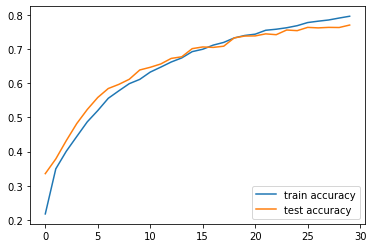

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
 
import os
os.chdir('/content/drive/My Drive')


fig = plt.figure()
loss_all, train_acc_all, test_acc_all
plt.plot(train_acc_all, label='train accuracy')
plt.plot(test_acc_all, label='test accuracy')
plt.legend(loc='lower right')

plt.savefig("picture/accuracy.png", dpi=100)
plt.show()


In [ ]:
model_weights = [] 
conv_layers = [] 
model_children = list(net.children())

# counter to keep count of the conv layers
counter = 0 
print(type(model_children[0][0]))
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
  for layer in model_children[i]:
    if type(layer) == nn.Conv2d:
      counter += 1
      model_weights.append(layer.weight)
      conv_layers.append(layer)

print(f"Total convolutional layers: {counter}")

<class 'torch.nn.modules.conv.Conv2d'>
Total convolutional layers: 6


In [ ]:
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([32, 3, 3, 3])
CONV: Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([32, 32, 3, 3])
CONV: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([64, 32, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([128, 64, 3, 3])
CONV: Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1)) ====> SHAPE: torch.Size([128, 128, 2, 2])


ValueError: ignored

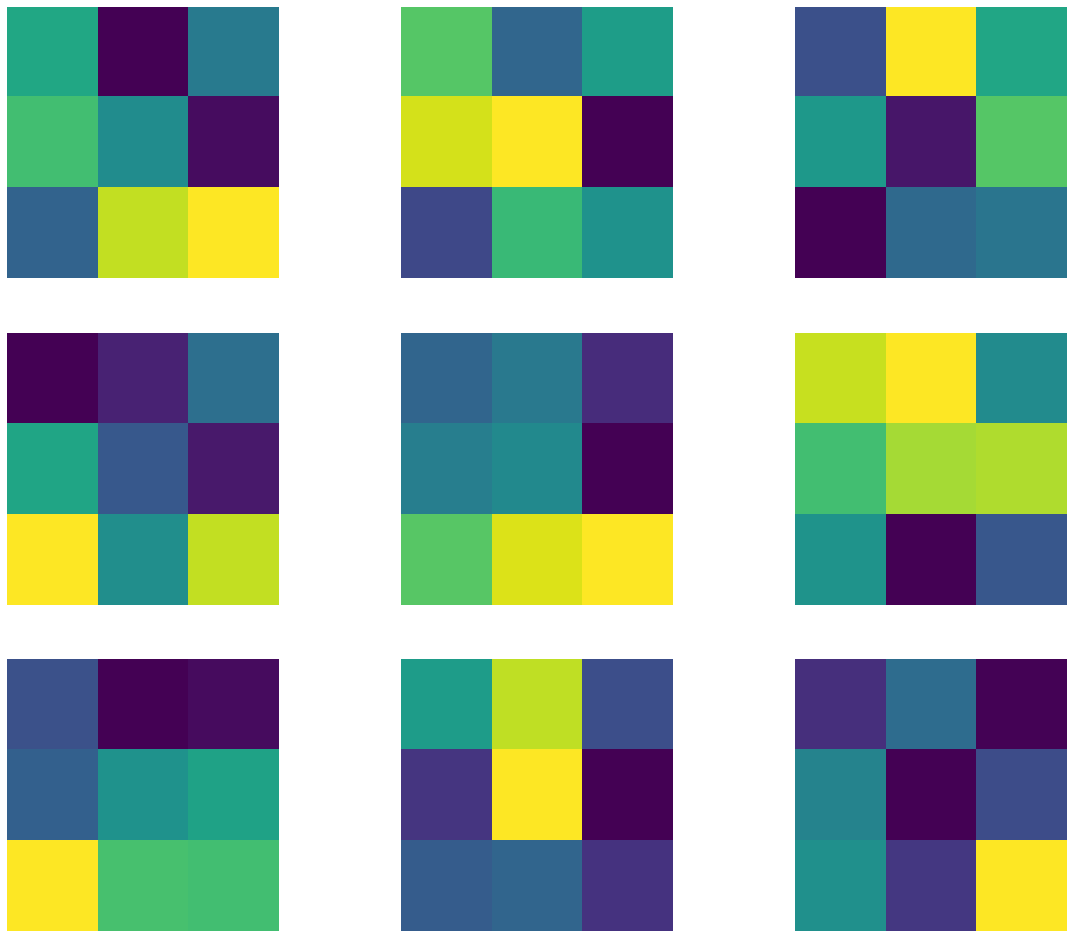

In [ ]:

# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(3, 3, i+1) # we have 5x5 filters and total of 16 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
    plt.savefig('first layer.png')
plt.show()

In [ ]:
for i, filter in enumerate(model_weights[1]):
    plt.subplot(4, 4, i+1) # we have 5x5 filters and total of 16 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
    plt.savefig('second layer.png')
plt.show()

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
example, _ = train_data[4]
plt.axis('off')

plt.imshow(example[0])
plt.savefig('car image')

In [ ]:
print(net.conv[0])
net.conv[0].register_forward_hook(get_activation('conv1'))
data, _ = train_data[4]
data=data.to(device)
data.unsqueeze_(0)
output = net(data)

k=0
act = activation['conv1'].squeeze()

fig,ax = plt.subplots(2,3,figsize=(12, 8))
for i in range(2):
  for j in range(3):
    ax[i,j].imshow(act[k].detach().cpu().numpy())
    k += 1

plt.savefig('fm1.png') 


In [ ]:
print(net.conv[1])
net.conv[1].register_forward_hook(get_activation('conv1'))
data, _ = train_data[4]
data=data.to(device)
data.unsqueeze_(0)
output = net(data)

k=0
act = activation['conv1'].squeeze()

fig,ax = plt.subplots(2,3,figsize=(12, 8))
for i in range(2):
  for j in range(3):
    ax[i,j].imshow(act[k].detach().cpu().numpy())
    k += 1

plt.savefig('relu1.png') 

In [ ]:
print(net.conv[0])
net.conv[3].register_forward_hook(get_activation('conv1'))
data, _ = train_data[4]
data=data.to(device)
data.unsqueeze_(0)
output = net(data)

k=0
act = activation['conv1'].squeeze()

fig,ax = plt.subplots(4,4,figsize=(12, 12))
for i in range(4):
  for j in range(4):
    ax[i,j].imshow(act[k].detach().cpu().numpy())
    k += 1

plt.savefig('conv2.png') 

In [ ]:
print(net.conv[0])
net.conv[4].register_forward_hook(get_activation('conv1'))
data, _ = train_data[4]
data=data.to(device)
data.unsqueeze_(0)
output = net(data)

k=0
act = activation['conv1'].squeeze()

fig,ax = plt.subplots(4,4,figsize=(12, 12))
for i in range(4):
  for j in range(4):
    ax[i,j].imshow(act[k].detach().cpu().numpy())
    k += 1

plt.savefig('relu2.png') 

In [ ]:
print(net.conv[0])
# Maxpool2d
net.conv[5].register_forward_hook(get_activation('conv1'))
data, _ = train_data[4]
data=data.to(device)
data.unsqueeze_(0)
output = net(data)

k=0
act = activation['conv1'].squeeze()
fig,ax = plt.subplots(4,4,figsize=(12, 12))
for i in range(4):
  for j in range(4):
    ax[i,j].imshow(act[k].detach().cpu().numpy())
    k += 1

plt.savefig('pool2.png') 

In [ ]:
print(net.conv[0])
# linear layer
net.conv[5].register_forward_hook(get_activation('conv1'))
data, _ = train_data[4]
data=data.to(device)
data.unsqueeze_(0)
output = net(data)

k=0
act = activation['conv1'].squeeze()
fig,ax = plt.subplots(4,4,figsize=(12, 12))
for i in range(4):
  for j in range(4):
    ax[i,j].imshow(act[k].detach().cpu().numpy())
    k += 1

plt.savefig('pool2.png') 

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
        'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
N_CLASSES = 10
class_correct = list(0. for i in range(N_CLASSES))
class_total = list(0. for i in range(N_CLASSES))
net.eval()
#test
total_correct = 0
total_num = 0
for x, label in test_iter:
    x,label = x.to(device) ,label.to(device)
    logits = net(x)
    pred = logits.argmax(dim=1)
    total_correct += torch.eq(pred,label).float().sum().item()
    total_num += x.size(0)  #即batch_size
      
    c = (pred == label).squeeze()
        
    for i in range(len(label)):
        _label = label[i]
        class_correct[_label] += c[i].item()
        class_total[_label] += 1
        
    acc = total_correct / total_num
    print('acc: ',acc)
 
    for i in range(N_CLASSES):
        print('Accuracy of %5s : %4f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

acc:  0.779296875
Accuracy of plane : 91.935484 %
Accuracy of   car : 89.655172 %
Accuracy of  bird : 68.750000 %
Accuracy of   cat : 52.941176 %
Accuracy of  deer : 67.391304 %
Accuracy of   dog : 63.636364 %
Accuracy of  frog : 81.250000 %
Accuracy of horse : 80.000000 %
Accuracy of  ship : 90.909091 %
Accuracy of truck : 91.111111 %
acc:  0.7783203125
Accuracy of plane : 83.035714 %
Accuracy of   car : 91.338583 %
Accuracy of  bird : 63.333333 %
Accuracy of   cat : 54.000000 %
Accuracy of  deer : 69.072165 %
Accuracy of   dog : 68.539326 %
Accuracy of  frog : 85.185185 %
Accuracy of horse : 78.431373 %
Accuracy of  ship : 90.109890 %
Accuracy of truck : 87.962963 %
acc:  0.7766927083333334
Accuracy of plane : 82.926829 %
Accuracy of   car : 91.228070 %
Accuracy of  bird : 63.194444 %
Accuracy of   cat : 52.777778 %
Accuracy of  deer : 71.779141 %
Accuracy of   dog : 67.153285 %
Accuracy of  frog : 86.470588 %
Accuracy of horse : 80.794702 %
Accuracy of  ship : 89.041096 %
Accuracy o